# # 1: Carga y preprocesamiento del dataset MNIST

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from typing import Tuple, Dict, Any
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definimos la transformación:
# - Convertir las imágenes a tensores (ToTensor)
# - Normalizar usando la media y desviación estándar de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar dataset de entrenamiento
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Cargar dataset de prueba
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoaders para manejar batches
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False
)

# Verificamos dimensiones y tipo de dato de un batch
images, labels = next(iter(train_loader))
print(f"Shape imágenes: {images.shape}")
print(f"Shape labels: {labels.shape}")
print(f"Tipo imágenes: {images.dtype}")
print(f"Rango de valores: {images.min().item():.4f} a {images.max().item():.4f}")

Shape imágenes: torch.Size([64, 1, 28, 28])
Shape labels: torch.Size([64])
Tipo imágenes: torch.float32
Rango de valores: -0.4242 a 2.8215


# # 2: Construcción del Modelo MLP (784 -> ... -> 10)

In [8]:

class MLP(nn.Module):
    """
    MLP para MNIST:
    - Entrada: 1x28x28 -> se aplana a 784
    - Salida: 10 logits (clases 0..9)
    - Por defecto: 1 capa oculta de 256 neuronas + ReLU + Dropout ligero
      (podemos variar esto en la parte de tuning)
    """
    def __init__(self, hidden_layers=(256,), dropout=0.1):
        super().__init__()
        layers = []
        in_features = 28 * 28  # 784

        # Construcción dinámica de capas ocultas
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU(inplace=True))
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            in_features = h

        # Capa de salida a 10 clases
        layers.append(nn.Linear(in_features, 10))

        # Secuencia
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.net(x)
        return logits

def count_params(model):
    return sum(p.numel() for p in model.parameters())

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Instanciamos el modelo (config base: una capa oculta de 256)
model = MLP(hidden_layers=(256,), dropout=0.1).to(device)
print(model)
print(f"Parámetros totales: {count_params(model):,}")

# Sanity check: pasar un batch por el modelo y revisar formas
images, labels = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    logits = model(images)
print("Shape de entrada:", images.shape)
print("Shape de salida:", logits.shape)

Device: cpu
MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)
Parámetros totales: 203,530
Shape de entrada: torch.Size([64, 1, 28, 28])
Shape de salida: torch.Size([64, 10])


# # 3: Tres configuraciones y utilidades de entrenamiento

In [9]:
# ---------- Semillas para reproducibilidad ----------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Transform y datasets (reaprovecha Parte 1) ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# ---------- MLP con activación configurable ----------
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return lambda: nn.ReLU(inplace=True)
    if name == "tanh":
        return lambda: nn.Tanh()
    if name in ("leakyrelu", "leaky_relu", "lrelu"):
        return lambda: nn.LeakyReLU(negative_slope=0.01, inplace=True)
    raise ValueError(f"Activación no soportada: {name}")

class MLP(nn.Module):
    def __init__(self, hidden_layers=(256,), activation="relu", dropout=0.1):
        super().__init__()
        layers = []
        in_features = 28 * 28
        act_factory = get_activation(activation)

        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(act_factory())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
            in_features = h

        layers.append(nn.Linear(in_features, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)

# ---------- Entrenamiento / evaluación ----------
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total

def run_experiment(cfg: Dict[str, Any]) -> Dict[str, Any]:
    # DataLoaders por config (batch size varía)
    train_loader = DataLoader(train_dataset, batch_size=cfg["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

    # Modelo
    model = MLP(hidden_layers=cfg["hidden_layers"],
                activation=cfg["activation"],
                dropout=cfg["dropout"]).to(device)

    # Criterio
    criterion = nn.CrossEntropyLoss()

    # Optimizador
    if cfg.get("optimizer", "adamw").lower() == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg.get("weight_decay", 0.0))
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

    # Loop
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    start = time.time()
    for epoch in range(1, cfg["epochs"] + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        te_loss, te_acc = evaluate(model, test_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)
        print(f'[ {cfg["id"]} ] Epoch {epoch:02d}/{cfg["epochs"]} | '
              f'Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | '
              f'Test  Loss: {te_loss:.4f} Acc: {te_acc:.4f}')
    elapsed = time.time() - start

    # Resultado final
    result = {
        "id": cfg["id"],
        "final_test_acc": history["test_acc"][-1],
        "final_test_loss": history["test_loss"][-1],
        "params": sum(p.numel() for p in model.parameters()),
        "elapsed_sec": elapsed,
        "history": history,
        "cfg": cfg
    }
    return result

Device: cpu


### Ejecutar experimentos A, B, C

In [10]:
configs = [
    {
        "id": "A_baseline",
        "hidden_layers": (256,),
        "activation": "relu",
        "dropout": 0.10,
        "optimizer": "adam",
        "lr": 1e-3,
        "batch_size": 64,
        "epochs": 5,
        "weight_decay": 0.0
    },
    {
        "id": "B_deeper_tanh",
        "hidden_layers": (512, 256),
        "activation": "tanh",
        "dropout": 0.20,
        "optimizer": "adam",
        "lr": 5e-4,
        "batch_size": 128,
        "epochs": 8,
        "weight_decay": 0.0
    },
    {
        "id": "C_wide_lrelu_wd",
        "hidden_layers": (512, 512, 256),
        "activation": "leakyrelu",
        "dropout": 0.30,
        "optimizer": "adamw",
        "lr": 7e-4,
        "batch_size": 256,
        "epochs": 10,
        "weight_decay": 1e-4
    }
]

results = []
for cfg in configs:
    print("\n" + "="*80)
    print(f"Iniciando experimento: {cfg['id']}")
    print("="*80)
    res = run_experiment(cfg)
    results.append(res)

# Ranking simple por accuracy de test (desc)
results_sorted = sorted(results, key=lambda r: r["final_test_acc"], reverse=True)
print("\n" + "#"*80)
print("RANKING (mejor → peor) por accuracy de test")
print("#"*80)
for i, r in enumerate(results_sorted, 1):
    print(f"{i}. {r['id']}: acc={r['final_test_acc']:.4f} | loss={r['final_test_loss']:.4f} | params={r['params']:,} | tiempo={r['elapsed_sec']:.1f}s")


Iniciando experimento: A_baseline


/tmp/ipython-input-645175058.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)
/tmp/ipython-input-645175058.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)


[ A_baseline ] Epoch 01/5 | Train Loss: 0.2341 Acc: 0.9300 | Test  Loss: 0.1176 Acc: 0.9632
[ A_baseline ] Epoch 02/5 | Train Loss: 0.1062 Acc: 0.9680 | Test  Loss: 0.0856 Acc: 0.9746
[ A_baseline ] Epoch 03/5 | Train Loss: 0.0763 Acc: 0.9759 | Test  Loss: 0.0790 Acc: 0.9755
[ A_baseline ] Epoch 04/5 | Train Loss: 0.0587 Acc: 0.9810 | Test  Loss: 0.0714 Acc: 0.9769
[ A_baseline ] Epoch 05/5 | Train Loss: 0.0487 Acc: 0.9842 | Test  Loss: 0.0738 Acc: 0.9776

Iniciando experimento: B_deeper_tanh
[ B_deeper_tanh ] Epoch 01/8 | Train Loss: 0.3140 Acc: 0.9098 | Test  Loss: 0.1593 Acc: 0.9524
[ B_deeper_tanh ] Epoch 02/8 | Train Loss: 0.1426 Acc: 0.9578 | Test  Loss: 0.1116 Acc: 0.9644
[ B_deeper_tanh ] Epoch 03/8 | Train Loss: 0.1018 Acc: 0.9695 | Test  Loss: 0.0912 Acc: 0.9705
[ B_deeper_tanh ] Epoch 04/8 | Train Loss: 0.0788 Acc: 0.9750 | Test  Loss: 0.0785 Acc: 0.9744
[ B_deeper_tanh ] Epoch 05/8 | Train Loss: 0.0617 Acc: 0.9807 | Test  Loss: 0.0728 Acc: 0.9767
[ B_deeper_tanh ] Epoch 06/

# # 4: Tuning de hiperparámetros (Random Search)

In [11]:
# --------- Espacios de búsqueda ---------
HIDDEN_SPACE = [
    (256,),
    (384,),
    (512,),
    (512, 256),
    (384, 192),
    (512, 512, 256),
]
ACTIVATIONS = ["relu", "tanh", "leakyrelu"]
OPTIMS = ["adam", "adamw"]
BATCH_SIZES = [64, 96, 128, 192, 256]
EPOCHS_RANGE = (6, 12)
DROPOUT_RANGE = (0.05, 0.35)
LR_RANGE = (1e-4, 3e-3)
WD_RANGE = (1e-6, 3e-4)

def sample_log_uniform(low, high):
    """Muestrea en [low, high] con distribución log-uniforme."""
    return float(np.exp(np.random.uniform(np.log(low), np.log(high))))

def sample_config(trial_id: int):
    hidden_layers = HIDDEN_SPACE[np.random.randint(0, len(HIDDEN_SPACE))]
    activation = np.random.choice(ACTIVATIONS)
    optim = np.random.choice(OPTIMS)
    batch_size = int(np.random.choice(BATCH_SIZES))
    epochs = int(np.random.randint(EPOCHS_RANGE[0], EPOCHS_RANGE[1] + 1))
    dropout = float(np.random.uniform(DROPOUT_RANGE[0], DROPOUT_RANGE[1]))
    lr = sample_log_uniform(LR_RANGE[0], LR_RANGE[1])
    weight_decay = sample_log_uniform(WD_RANGE[0], WD_RANGE[1]) if optim == "adamw" else 0.0

    return {
        "id": f"T{trial_id:02d}",
        "hidden_layers": tuple(hidden_layers),
        "activation": activation,
        "dropout": dropout,
        "optimizer": optim,
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "weight_decay": weight_decay
    }

# --------- Runner de Random Search ---------
def random_search(n_trials: int = 12, time_budget_sec: float = None):
    """
    n_trials: cantidad de configuraciones a probar.
    time_budget_sec: si querés cortar por tiempo total aprox. (opcional).
    """
    results = []
    t0 = time.time()

    for t in range(1, n_trials + 1):
        if time_budget_sec is not None and (time.time() - t0) > time_budget_sec:
            print("\nSe alcanzó el presupuesto de tiempo; se detiene la búsqueda.")
            break

        cfg = sample_config(t)
        print("\n" + "="*90)
        print(f"Random Search - Trial {t}/{n_trials}  |  cfg: {cfg}")
        print("="*90)

        try:
            res = run_experiment(cfg)
            results.append(res)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print("OOM: saltando esta config. Probá reducir batch_size o capas.")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    if not results:
        print("No hay resultados. Revisá el espacio de búsqueda o errores en entrenamiento.")
        return []

    # Ordenar por accuracy de test (desc)
    results_sorted = sorted(results, key=lambda r: r["final_test_acc"], reverse=True)

    # Mostrar top-5
    print("\n" + "#"*90)
    print("TOP-5 configuraciones por accuracy de test")
    print("#"*90)
    for i, r in enumerate(results_sorted[:5], 1):
        cfg = r["cfg"]
        print(f"{i}. {r['id']} | acc={r['final_test_acc']:.4f} | loss={r['final_test_loss']:.4f} | "
              f"params={r['params']:,} | tiempo={r['elapsed_sec']:.1f}s | "
              f"capas={cfg['hidden_layers']} act={cfg['activation']} do={cfg['dropout']:.2f} "
              f"opt={cfg['optimizer']} lr={cfg['lr']:.5f} wd={cfg['weight_decay']:.1e} "
              f"bs={cfg['batch_size']} ep={cfg['epochs']}")

    best = results_sorted[0]
    print("\nMejor configuración encontrada:")
    print(best["cfg"])
    print(f"Accuracy test: {best['final_test_acc']:.4f}  |  Loss test: {best['final_test_loss']:.4f}")
    return results_sorted

search_results = random_search(n_trials=3)


Random Search - Trial 1/3  |  cfg: {'id': 'T01', 'hidden_layers': (512, 256), 'activation': np.str_('relu'), 'dropout': 0.2290550473839461, 'optimizer': np.str_('adam'), 'lr': 0.0004555636200065776, 'batch_size': 128, 'epochs': 10, 'weight_decay': 0.0}


/tmp/ipython-input-645175058.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)
/tmp/ipython-input-645175058.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  x, y = x.to(device), x.to(device).new_tensor(y, dtype=torch.long).to(device)


[ T01 ] Epoch 01/10 | Train Loss: 0.3306 Acc: 0.9023 | Test  Loss: 0.1295 Acc: 0.9597
[ T01 ] Epoch 02/10 | Train Loss: 0.1314 Acc: 0.9610 | Test  Loss: 0.0892 Acc: 0.9726
[ T01 ] Epoch 03/10 | Train Loss: 0.0902 Acc: 0.9721 | Test  Loss: 0.0748 Acc: 0.9769
[ T01 ] Epoch 04/10 | Train Loss: 0.0715 Acc: 0.9773 | Test  Loss: 0.0734 Acc: 0.9761
[ T01 ] Epoch 05/10 | Train Loss: 0.0593 Acc: 0.9814 | Test  Loss: 0.0640 Acc: 0.9803
[ T01 ] Epoch 06/10 | Train Loss: 0.0468 Acc: 0.9849 | Test  Loss: 0.0632 Acc: 0.9806
[ T01 ] Epoch 07/10 | Train Loss: 0.0411 Acc: 0.9864 | Test  Loss: 0.0571 Acc: 0.9824
[ T01 ] Epoch 08/10 | Train Loss: 0.0378 Acc: 0.9878 | Test  Loss: 0.0569 Acc: 0.9827
[ T01 ] Epoch 09/10 | Train Loss: 0.0323 Acc: 0.9891 | Test  Loss: 0.0558 Acc: 0.9835
[ T01 ] Epoch 10/10 | Train Loss: 0.0289 Acc: 0.9904 | Test  Loss: 0.0569 Acc: 0.9824

Random Search - Trial 2/3  |  cfg: {'id': 'T02', 'hidden_layers': (512,), 'activation': np.str_('leakyrelu'), 'dropout': 0.0928600453765822

# # 5: Evaluación, comparación y ranking


=== Ranking (mejor → peor) por accuracy de test ===
 rank              id  test_acc  test_loss  params   time_s          layers activation  dropout optimizer     lr  weight_decay  batch_size  epochs
    1 C_wide_lrelu_wd    0.9835     0.0609  798474 187.8031 (512, 512, 256)  leakyrelu   0.3000     adamw 0.0007        0.0001         256      10
    2   B_deeper_tanh    0.9786     0.0672  535818 149.9243      (512, 256)       tanh   0.2000      adam 0.0005        0.0000         128       8
    3      A_baseline    0.9776     0.0738  203530  91.2855          (256,)       relu   0.1000      adam 0.0010        0.0000          64       5


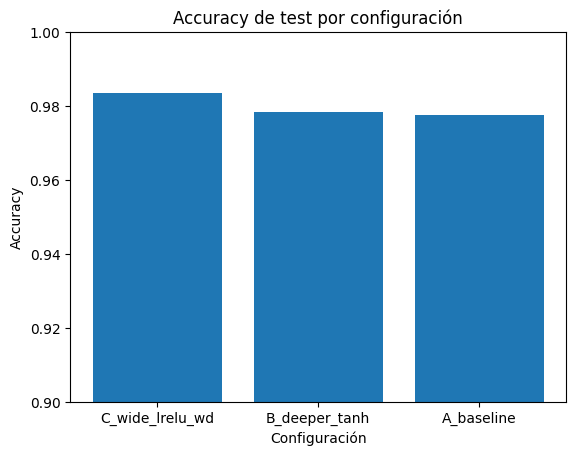

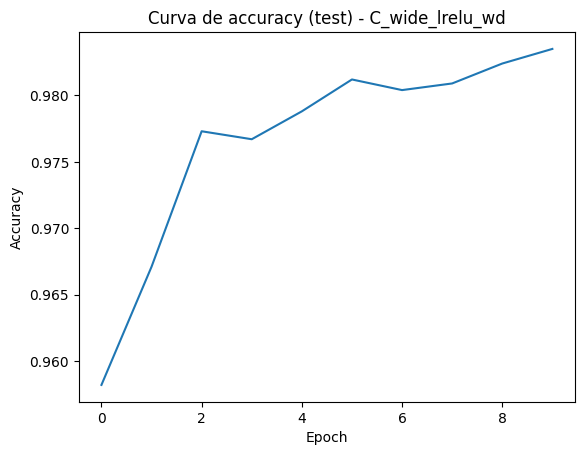

In [12]:

def results_to_df(results):
    rows = []
    for r in results:
        cfg = r["cfg"]
        rows.append({
            "id": r["id"],
            "test_acc": r["final_test_acc"],
            "test_loss": r["final_test_loss"],
            "params": r["params"],
            "time_s": r["elapsed_sec"],
            "layers": cfg["hidden_layers"],
            "activation": cfg["activation"],
            "dropout": cfg["dropout"],
            "optimizer": cfg["optimizer"],
            "lr": cfg["lr"],
            "weight_decay": cfg["weight_decay"],
            "batch_size": cfg["batch_size"],
            "epochs": cfg["epochs"],
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("test_acc", ascending=False).reset_index(drop=True)
    df.insert(0, "rank", df.index + 1)
    return df

df_models = results_to_df(results)
print("\n=== Ranking (mejor → peor) por accuracy de test ===")
print(df_models[["rank","id","test_acc","test_loss","params","time_s","layers","activation","dropout","optimizer","lr","weight_decay","batch_size","epochs"]]
      .to_string(index=False, float_format=lambda x: f"{x:.4f}"))

plt.figure()
plt.bar(df_models["id"], df_models["test_acc"])
plt.title("Accuracy de test por configuración")
plt.xlabel("Configuración")
plt.ylabel("Accuracy")
plt.ylim(0.90, 1.00)
plt.show()

best_id = df_models.iloc[0]["id"]
best_hist = next(r for r in results if r["id"] == best_id)["history"]

plt.figure()
plt.plot(best_hist["test_acc"])
plt.title(f"Curva de accuracy (test) - {best_id}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## ¿Qué hiperparámetros influyeron más y por qué?

Resultados: C_wide_lrelu_wd 0.9835 > B_deeper_tanh 0.9786 > A_baseline 0.9776.

- Capacidad (capas/neur.) -> mayor impacto. Pasar de (256,) a (512,512,256) elevó el techo de precisión: más capacidad = más patrones capturados.
- Activación: ReLU/LeakyReLU > Tanh (Tanh se satura y frena el gradiente; ReLU/LeakyReLU entrenan más estable y rápido).
- Regularización: Dropout + AdamW/weight decay permitieron que el modelo grande generalice (evita overfitting).
- LR y epochs: dentro del rango usado fueron adecuados; influyeron menos que lo anterior (mal elegidos sí serían críticos).
- Batch size: efecto menor en accuracy; impacta más en tiempo/estabilidad.

El salto principal vino de más capacidad + activaciones tipo ReLU/LeakyReLU, sostenido por regularización; con LR razonable y epochs suficientes se alcanzó 0.9835.
